In [1]:
from power_spectrum import *
from matplotlib.pyplot import *
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
def training_fn_generator(x,p):
    def f():
        dataset = tf.data.Dataset.from_tensor_slices((x.astype('float32'), p.astype('float32')))
        dataset = dataset.repeat().shuffle(1000).batch(batch_size)
        return dataset
    return f

def testing_fn_generator(x,p):
    def f():
        dataset = tf.data.Dataset.from_tensor_slices((x.astype('float32'), p.astype('float32')))
        dataset = dataset.batch(batch_size)
        return dataset
    return f

In [3]:
nsims_train = 10**5
nsims_test = 10**3

batch_size = 32

def spectral_index(params):
    def f(k):
        if k==0:
            return zeros(len(params))
        return k**(-4*params)
    return f

sims = lambda p: fast_gaussian(spectral_index(p[:,0]), fnl=10.**(6*p[:,1]-3))

In [4]:
p_train = rand(nsims_train,2)
p_test = rand(nsims_test, 2)

x_train = sims(p_train)
x_test = sims(p_test)

/global/u2/a/avirukt/proj/power_spectrum.py:139: RuntimeWarning: invalid value encountered in true_divide
  field /= k2
/global/u2/a/avirukt/proj/power_spectrum.py:139: RuntimeWarning: invalid value encountered in true_divide
  field /= k2


In [5]:
from ipywidgets import interactive

def plot_field(x):
    m = amax(abs(x))
    imshow(x, vmin=-m, vmax=m, cmap="bwr")
    colorbar()

interactive(lambda spec_ind, f_nl: plot_field(sims(np.array([[spec_ind,f_nl]]))[0]), spec_ind=(0.,1.), f_nl=(0.,1))

interactive(children=(FloatSlider(value=0.5, description='spec_ind', max=1.0), FloatSlider(value=0.5, descript…

array([ 0.57946062,  0.31148083])

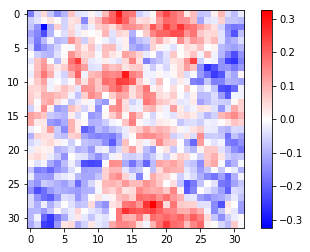

In [6]:
i = randint(nsims_train)
plot_field(x_train[i])
p_train[i]

In [7]:
def triangle_plot(samples, labels=None, title=None, nbins=100, bounds=None, expected=None, truth=None):
    n = samples.shape[-1]
    if bounds is None:
        bounds = [(amin(s), amax(s)) for s in samples.T]
    f,ax = subplots(n,n,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*n,4*n))
    if title is not None:
        suptitle(title)
    bins = [linspace(*bounds[i],nbins+1) for i in range(n)]
    for i in range(n):
        ax[i,i].hist(samples[:,i],bins=bins[i],density=True)
        if i<n-1:
            ax[i,i].set_xticks([])
        ax[i,i].set_yticks([])
        ax[i,i].set_xlim(*bounds[i])
        if expected is not None:
            mesh = linspace(*bounds[i], 500)
            ax[i,i].plot(mesh,expected[i](mesh))
        if truth is not None:
            ax[i,i].axvline(truth[i], c="r")
        for j in range(i):
            if i<n-1:
                ax[i,j].set_xticks([])
            if j>0:
                ax[i,j].set_yticks([])
            ax[i,j].hist2d(samples[:,j],samples[:,i], cmap="Blues", bins=[bins[j],bins[i]])
            ax[-(i+1),-(j+1)].axis("off")
            ax[i,j].set_ylim(*bounds[i])
            ax[i,j].set_xlim(*bounds[j])
            if truth is not None:
                ax[i,j].scatter(truth[j],truth[i],c="r",marker="x")
        ax[-1,i].set_xlabel(labels[i])
        if i>0:
            ax[i,0].set_ylabel(labels[i])
        #return f

In [8]:
class LFI(tf.estimator.Estimator):
    def plot_summaries(self, x, p, nbins=100):
        testing_fn = testing_fn_generator(x,p)
        stats = array([p["stat"] for p in self.predict(testing_fn)])
        nbands = stats.shape[-1]
        f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
        suptitle("Summary statistics")
        for i in range(nbands):
            for j in range(nbands):
                ax[i,j].hist2d(p[:,j],stats[:,i],nbins,cmap="Blues")
        for i in range(nbands):
            ax[i,0].set_ylabel(f"statistic {i+1}")
            ax[-1,i].set_xlabel(self.labels[i])
        #return f
    
    def plot_posteriors(self, x, p, compare=None, **kwargs):
        testing_fn = testing_fn_generator(x,p)
        for i,m in enumerate(self.predict(testing_fn)):
            if compare is not None:
                kwargs["expected"] = compare(x[i])
            yield triangle_plot(m["samples"], labels=self.labels, title=f"sample {i+1}", truth=p[i], **kwargs)

In [19]:
class two_params_1(LFI):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=0.2,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=dropout,training=training),256,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=dropout,training=training),64,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),16,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),4,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=dropout,training=training),2)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.tanh)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.00001).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
        self.labels = label_columns
    
model = two_params_1(["field"], ["power spectral index","$f_{NL}$"], model_dir='/global/cscratch1/sd/avirukt/models/fnl1')
model.train(training_fn_generator(x_train, p_train), max_steps=30*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/fnl1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aab2ba17d68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnl1/model.ckpt-78125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


8

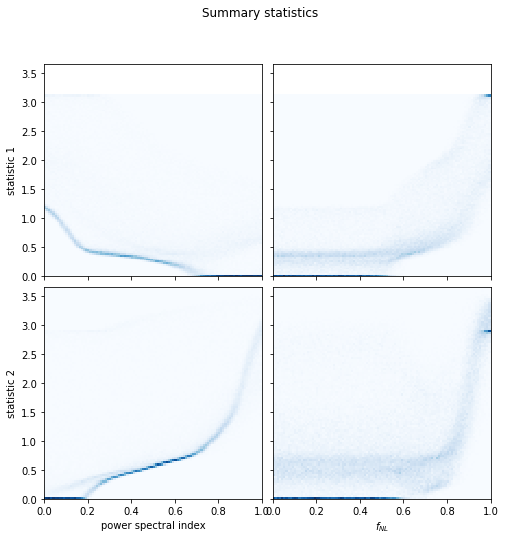

In [16]:
model.plot_summaries(x_train,p_train)
8

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnl1/model.ckpt-78125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0.98, 'Summary statistics: train data')

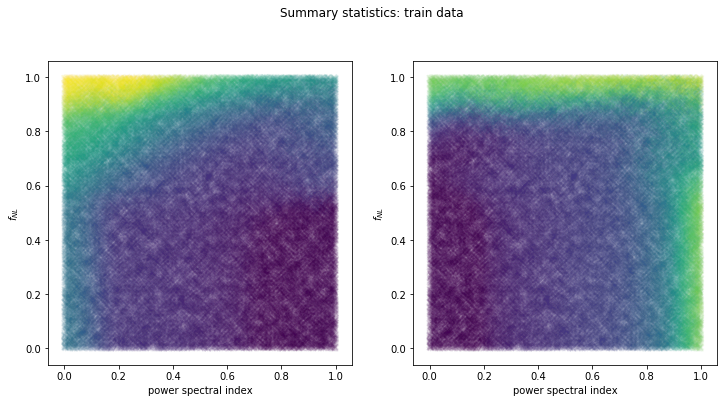

In [11]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_train, p_train))])
f,ax = subplots(1,2,figsize=(12,6))
ax[0].scatter(p_train[:,0],p_train[:,1],c=stats[:,0],marker="x",alpha=0.05)
ax[0].set_aspect("equal")
ax[0].set_xlabel(model.labels[0])
ax[0].set_ylabel(model.labels[1])
ax[1].scatter(p_train[:,0],p_train[:,1],c=stats[:,1],marker="x",alpha=0.05)
ax[1].set_aspect("equal")
ax[1].set_xlabel(model.labels[0])
ax[1].set_ylabel(model.labels[1])
suptitle("Summary statistics: train data")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnl1/model.ckpt-78125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


8

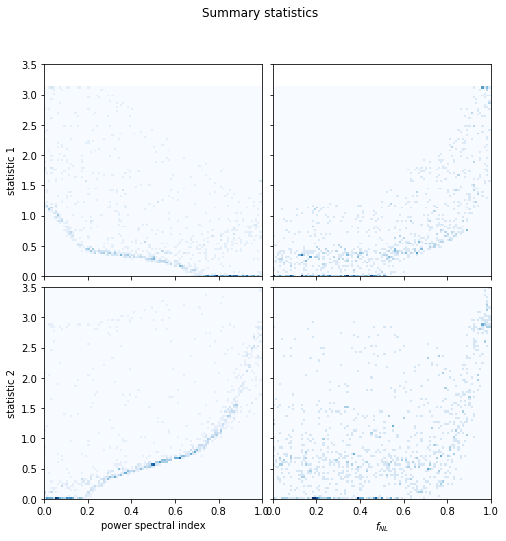

In [12]:
model.plot_summaries(x_test,p_test)
8

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnl1/model.ckpt-78125
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0.98, 'Summary statistics: test data')

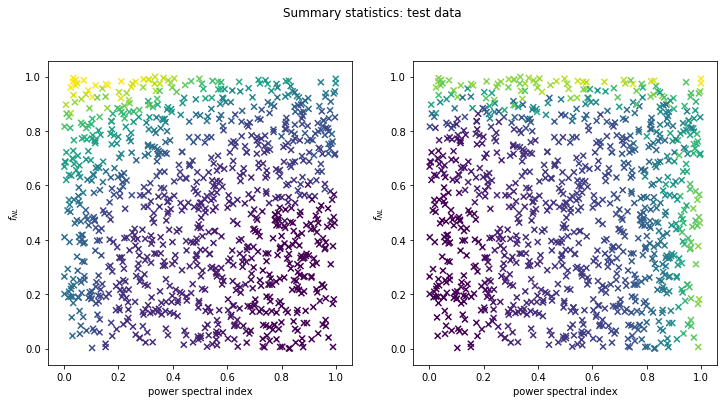

In [13]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_test, p_test))])
f,ax = subplots(1,2,figsize=(12,6))
ax[0].scatter(p_test[:,0],p_test[:,1],c=stats[:,0],marker="x")
ax[0].set_aspect("equal")
ax[0].set_xlabel(model.labels[0])
ax[0].set_ylabel(model.labels[1])
ax[1].scatter(p_test[:,0],p_test[:,1],c=stats[:,1],marker="x")
ax[1].set_aspect("equal")
ax[1].set_xlabel(model.labels[0])
ax[1].set_ylabel(model.labels[1])
suptitle("Summary statistics: test data")

In [20]:
posteriors = model.plot_posteriors(x_test,p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnl1/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


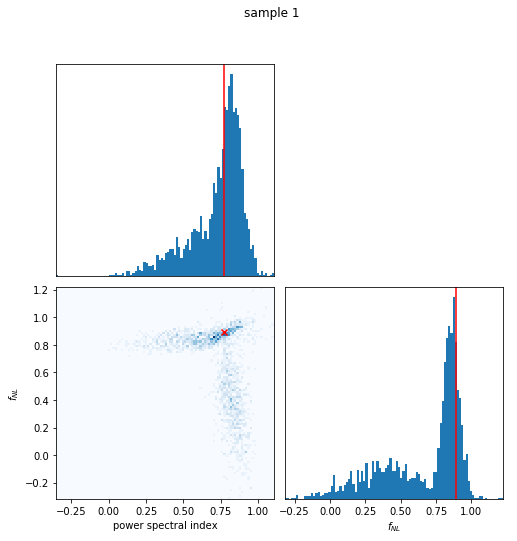

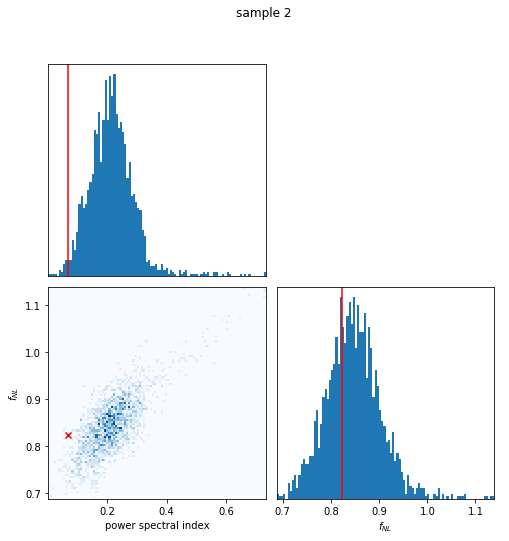

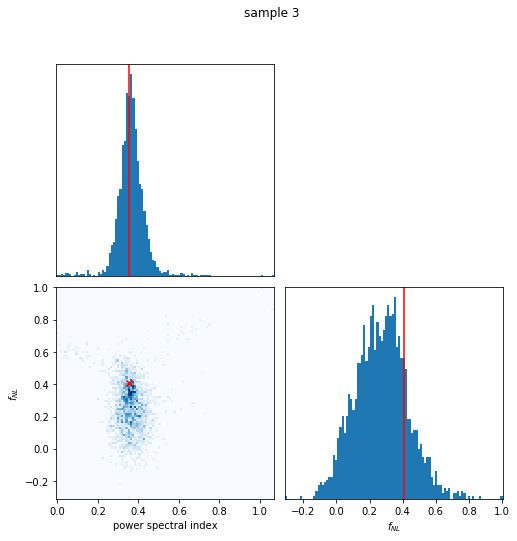

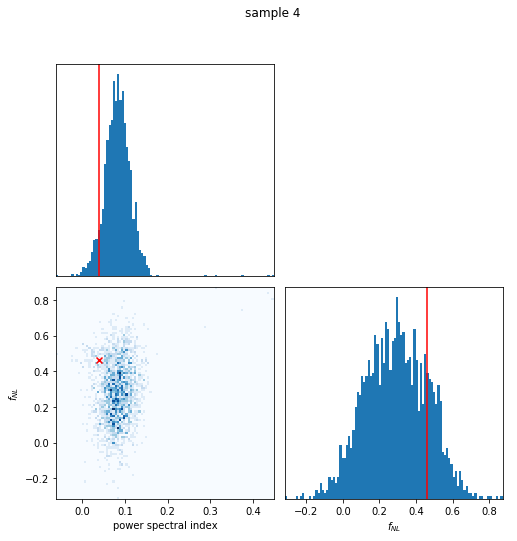

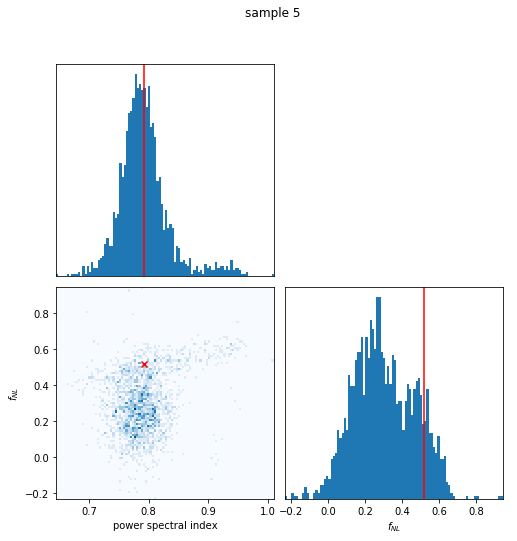

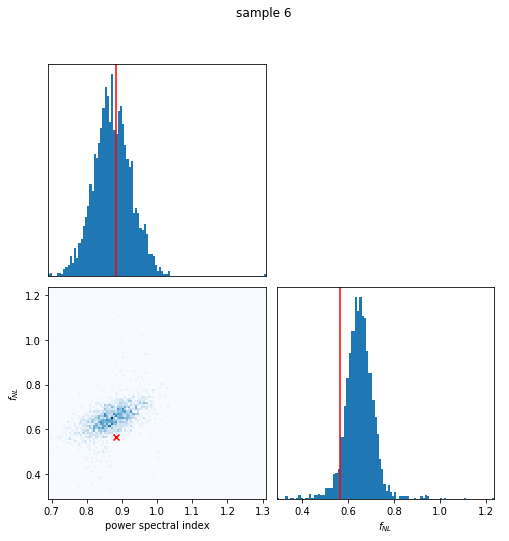

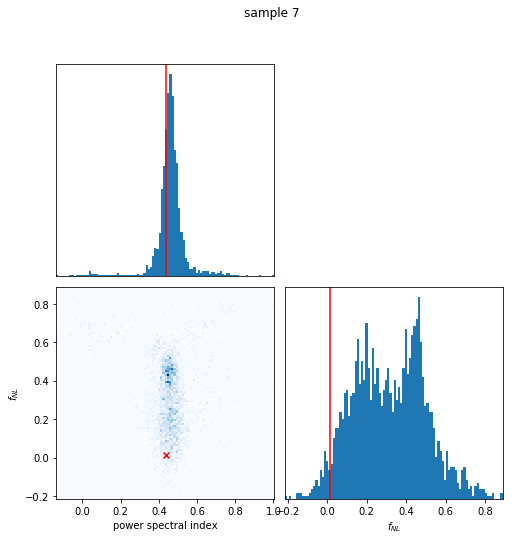

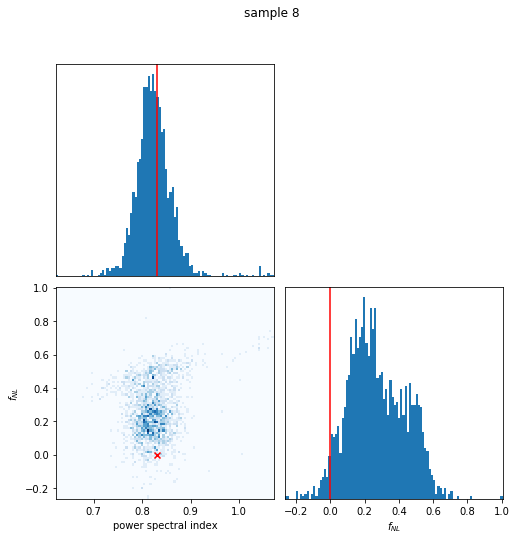

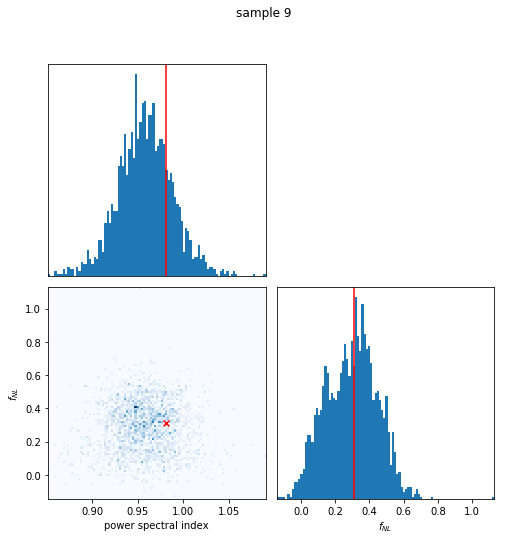

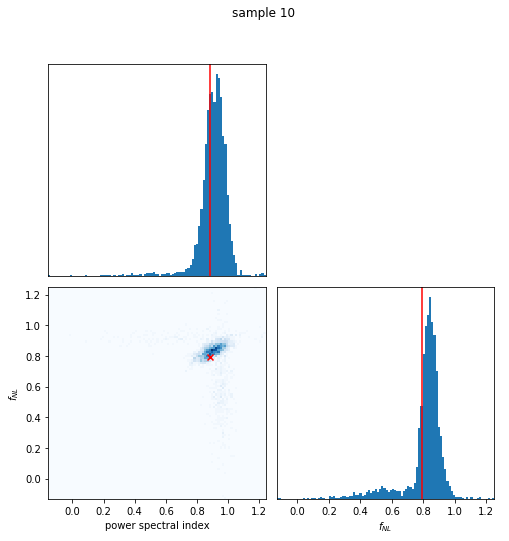

In [21]:
for i in range(10):
    next(posteriors)